In [1]:
import numpy
import seaborn as sns
import pandas as pd
import matplotlib
from matplotlib import *
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
life_exp_data = pd.read_csv("data/africa-mflifeexpectancy.csv")
dp3_vacc_data = pd.read_csv("data/africa-dtpvaccine.csv")
ms_vacc_data = pd.read_csv("data/africa-measlesvaccine.csv")
lit_data = pd.read_csv("data/africa-literacy.csv")
corrupt_data = pd.read_csv("data/africa-corruption.csv")
food_energy_data = pd.read_csv("data/africa-dietenergy.csv")
conflict_data = pd.read_csv("data/africa-conflicthistory.csv")
sanit_data = pd.read_csv("data/africa-sanitation.csv")
econ_free_data = pd.read_csv("data/africa-economicfreedom.csv")

Average Life Expectancy 49


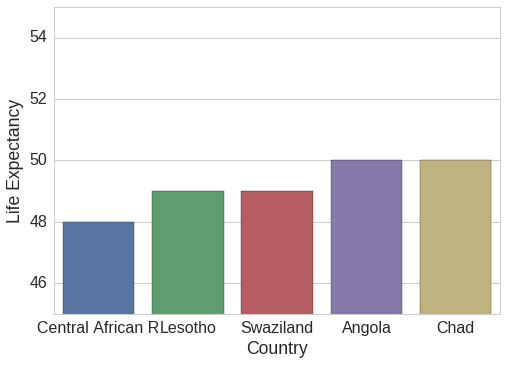

In [3]:
f_bool = (life_exp_data['Indicator']=='Life expectancy at birth female') & (life_exp_data['Year']==2014)
m_bool = (life_exp_data['Indicator']=='Life expectancy at birth male') & (life_exp_data['Year']==2014)
le_country = [unicode(i,"utf-8") for i in life_exp_data['Country'][m_bool]]
le_value = map(int,life_exp_data['Value'][m_bool])
le_zip = zip(le_value,le_country)
le_zip.sort()
low_zip_country = [i[1][:17] for i in le_zip[:5]]
low_zip_value = [i[0] for i in le_zip[:5]]
high_zip_country = [i[1][:17] for i in le_zip[-5:]]
high_zip_value = [i[0] for i in le_zip[-5:]]
sns.set(style = 'whitegrid',font_scale=1.6)
ax1 = sns.barplot(x=low_zip_country,y=low_zip_value)
ax1.set_ylim(45,55)
ax1.set_ylabel('Life Expectancy')
ax1.set_xlabel('Country')
print 'Average Life Expectancy',sum(low_zip_value)/len(low_zip_value)

Average Life Expectancy 71


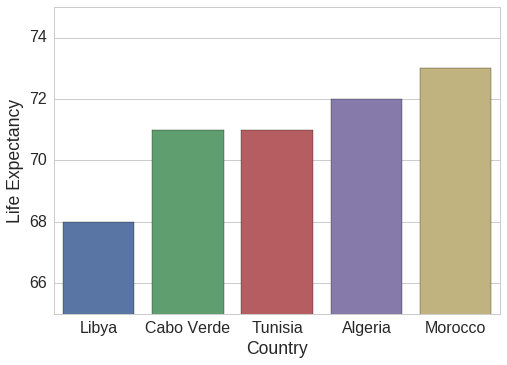

In [4]:
sns.set(style = 'whitegrid',font_scale=1.6)
ax2 = sns.barplot(x=high_zip_country,y=high_zip_value)
ax2.set_ylim(65,75)
ax2.set_ylabel('Life Expectancy')
ax2.set_xlabel('Country')
print 'Average Life Expectancy',sum(high_zip_value)/len(high_zip_value)

In [5]:
countries = ms_vacc_data['Country'].unique()

In [6]:
print 'LE',life_exp_data['Year'].unique(),'DP3',dp3_vacc_data['Year'].unique(),'Meas', ms_vacc_data['Year'].unique(), \
  'Lit',lit_data['Year'].unique(),'Corr',corrupt_data['Year'].unique(),'FE',food_energy_data['Year'].unique(), \
  'Conf',conflict_data['Year'].unique(),'San',sanit_data['Year'].unique(),'EF',econ_free_data['Year'].unique()

LE [1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014] DP3 [2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013] Meas [1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014] Lit [1990 1991 1992 1993 1994 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013] Corr [1996 1998 2000 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014] FE [1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016] Conf [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014] San [1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015] EF [1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 

In [7]:
years = corrupt_data['Year'].unique()

In [8]:
def norm_year_count(in_data,n_countries,n_years):
  in_data2 = pd.pivot_table(in_data,values='Value', index=['Country'],columns=['Year'])
  in_data2 = in_data2.reindex(n_countries)
  in_data2 = in_data2.transpose()
  in_data2 = in_data2.reindex(n_years)  
  in_data2 = in_data2.apply(pd.Series.interpolate)
  in_data2 = in_data2.transpose()
  return in_data2

In [9]:
life_exp_data2 = norm_year_count(life_exp_data,countries,years)
dp3_vacc_data2 = norm_year_count(dp3_vacc_data,countries,years)
ms_vacc_data2 = norm_year_count(ms_vacc_data,countries,years)
lit_data2 = norm_year_count(lit_data,countries,years)
corrupt_data2 = norm_year_count(corrupt_data,countries,years)
food_energy_data2 = norm_year_count(food_energy_data,countries,years)
conflict_data2 = norm_year_count(conflict_data,countries,years)
sanit_data2 = norm_year_count(sanit_data,countries,years)
econ_free_data2 = norm_year_count(econ_free_data,countries,years)

In [33]:
life_exp_2014 = life_exp_data2[2014]
life_exp_2014.name="life_expectancy"
dp3_vacc_2014 = dp3_vacc_data2[2014]
dp3_vacc_2014.name='dtp_vaccine'
ms_vacc_2014 = ms_vacc_data2[2014]
ms_vacc_2014.name='measles_vaccine'
lit_2014 = lit_data2[2014]
lit_2014.name='literacy'
corrupt_2014 = corrupt_data2[2014]
corrupt_2014.name='corruption'
food_energy_2014 = food_energy_data2[2014]
food_energy_2014.name='food_energy'
conflict_2014 = conflict_data2[2014]
conflict_2014.name='conflict'
sanit_2014 = sanit_data2[2014]
sanit_2014.name='sanitation'
econ_free_2014 = econ_free_data2[2014]
econ_free_2014.name='economic_freedom'

In [34]:
data_2014 = pd.concat([life_exp_2014,dp3_vacc_2014,ms_vacc_2014,lit_2014,corrupt_2014,food_energy_2014, 
                       conflict_2014,sanit_2014,econ_free_2014],axis=1)

In [45]:
plot_data_2014 = data_2014.dropna()

In [48]:
from scipy import stats
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = matplotlib.pyplot.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

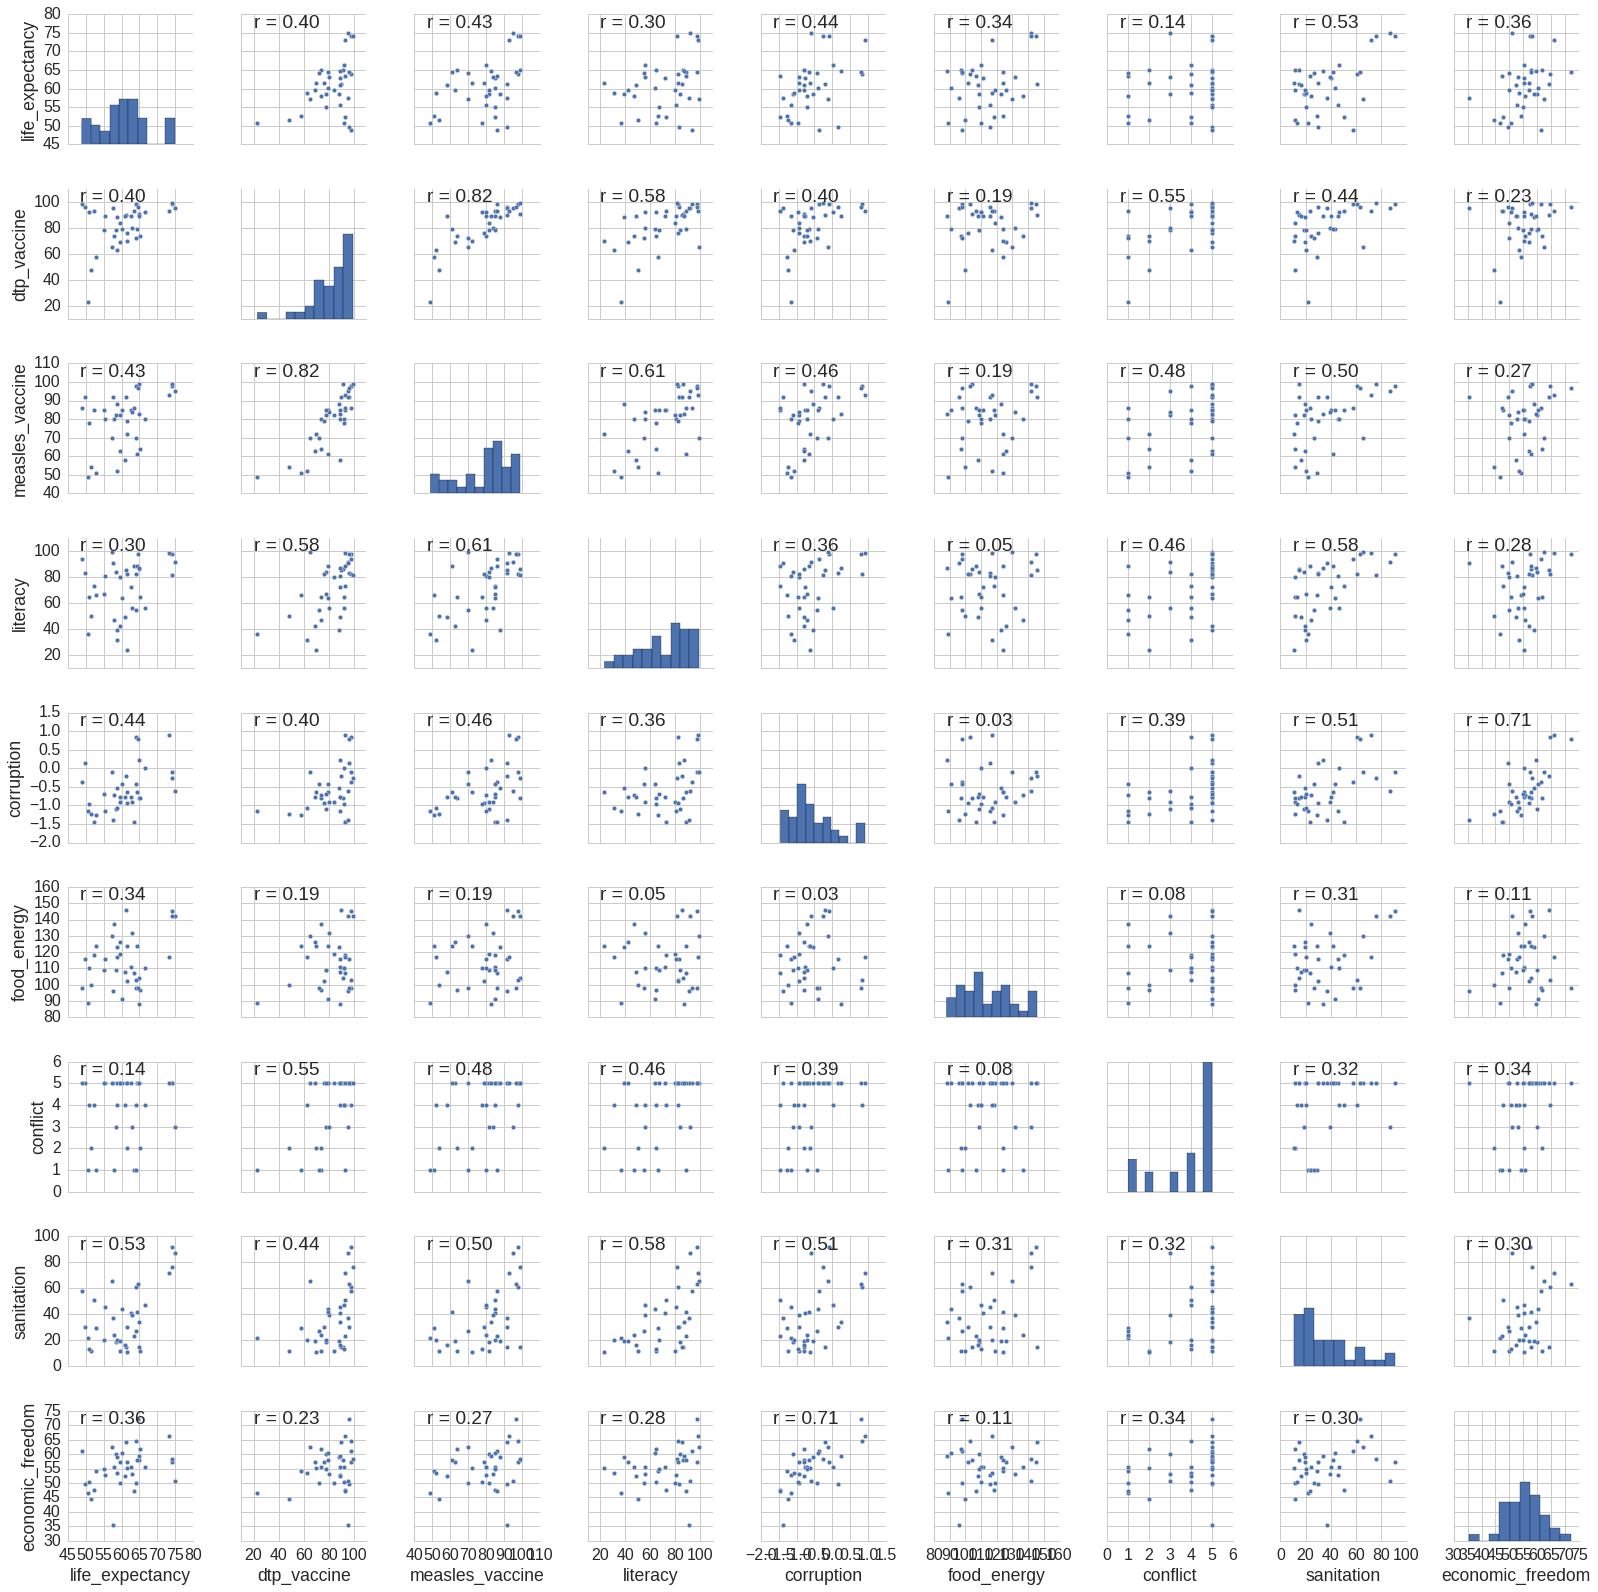

In [49]:
life_exp_correlations = sns.pairplot(plot_data_2014)
life_exp_correlations.map_upper(corrfunc)
life_exp_correlations.map_lower(corrfunc)

In [37]:
from sklearn import preprocessing

In [40]:
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
y_data_2014 = data_2014['life_expectancy']
imp_data_2014 = imp.fit_transform(data_2014.drop(['life_expectancy'],1))

In [43]:
scaler = preprocessing.StandardScaler()
scale_data_2014 = scaler.fit_transform(imp_data_2014)